In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
import numpy as np

from IPython import get_ipython
import random
import matplotlib.pyplot as plt
from IPython import display
from tqdm.notebook import tqdm
from dynamic_env import TaskEnv_drift


In [47]:

class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 32),  # 输入维度是 state_dim
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, action_dim),  # 输出维度是 action_dim
            nn.Softmax(dim=-1)
        )

    def forward(self, state):
        return self.fc(state)

# 定义 MAML 算法
class MAML:
    def __init__(self, state_dim, action_dim, lr_inner=0.01, lr_outer=0.001):
        self.policy = PolicyNetwork(state_dim, action_dim)
        self.lr_inner = lr_inner  # 内循环学习率
        self.lr_outer = lr_outer  # 外循环学习率
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr_outer)

    def adapt(self, task, num_steps=1):
        """
        内循环：在单个任务上快速适应
        """
        fast_weights = list(self.policy.parameters())  # 获取所有参数的副本
        for step in range(num_steps):
            states, actions, rewards = self.sample_trajectory(task)
            loss = self.compute_loss(states, actions, rewards)
            grads = torch.autograd.grad(loss, fast_weights, create_graph=True)
            fast_weights = [w - self.lr_inner * g for w, g in zip(fast_weights, grads)]
        return fast_weights

    def meta_train(self, tasks: list[TaskEnv_drift], num_iterations=None, drift_episode=None):
        """
        外循环：在多个任务上优化初始参数
        :param drift_episode: 在指定 iteration 触发 env drift（None 表示无 drift）
        :return: avg_rewards (List[float]), all_rewards (List[List[float]])
        """
        all_rewards = []  # 存储每个任务在每个 iteration 的 reward
        avg_rewards = []  # 存储每个 iteration 的平均 reward

        for iteration in range(num_iterations):
            if drift_episode is not None and iteration == drift_episode:
                for task in tasks:
                    task.drift()  # 触发环境变化
                print(f"------ Env Drift at Iteration {iteration} ------")

            self.optimizer.zero_grad()
            iteration_rewards = []

            for task in tasks:
                fast_weights = self.adapt(task)
                states, actions, rewards = self.sample_trajectory(task, fast_weights)
                loss = self.compute_loss(states, actions, rewards, fast_weights)
                iteration_rewards.append(rewards.sum().item())

            avg_reward = np.mean(iteration_rewards)
            avg_rewards.append(avg_reward)
            all_rewards.append(iteration_rewards)

            # 更新外循环（这里简化了 loss 计算）
            loss = self.compute_loss(*self.sample_trajectory(tasks[0]))  # 示例：用第一个任务计算 loss
            loss.backward()
            self.optimizer.step()
            #print(f"Iteration {iteration}, Avg Reward: {avg_reward}")
        return avg_rewards, all_rewards


    def compute_loss(self, states, actions, rewards, params=None):
        """
        计算策略梯度损失
        """
        if params is None:
            probs = self.policy(states)
        else:
            probs = self.forward_with_params(states, params)
        log_probs = torch.log(probs.gather(1, actions.unsqueeze(1)))
        loss = -(log_probs * rewards).mean()
        return loss

    def forward_with_params(self, states, params):
        x = states
        param_iter = iter(params)  # 创建一个参数迭代器
        for layer in self.policy.fc:
            if isinstance(layer, nn.Linear):
                weight = next(param_iter)  # 获取权重
                bias = next(param_iter)    # 获取偏置
                x = torch.nn.functional.linear(x, weight, bias)
            else:
                x = layer(x)
        return x

    def sample_trajectory(self, task: TaskEnv_drift, params=None):
        """
        在任务中采样一条轨迹
        """
        states, actions, rewards = [], [], []
        state = task.reset()
        done = False
        while not done:
            # 将状态转换为 one-hot 编码
            state_idx = task.states.index(state)  # 获取状态的索引
            state_onehot = np.zeros(len(task.states))  # 创建 one-hot 向量
            state_onehot[state_idx] = 1
            state_tensor = torch.FloatTensor(state_onehot)  # 转换为 PyTorch 张量

            # 选择动作
            if params is None:
                action_probs = self.policy(state_tensor)
            else:
                action_probs = self.forward_with_params(state_tensor, params)
            action = torch.multinomial(action_probs, 1).item()

            # 执行动作
            next_state, reward, done, _ = task.step(action)

            # 存储轨迹数据
            states.append(state_tensor)
            actions.append(action)
            rewards.append(reward)
            state = next_state

        # 将轨迹数据转换为 PyTorch 张量
        states = torch.stack(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        return states, actions, rewards
    
    def test_performance(self, tasks, num_tasks=5):
        """测试当前策略在多个任务上的平均性能"""
        total_rewards = []
        for task in tasks:
            rewards = []
            for _ in range(num_tasks):
                _, _, r = self.sample_trajectory(task)
                rewards.append(sum(r))
            total_rewards.append(np.mean(rewards))
        return np.mean(total_rewards)



In [48]:
# 主程序
tasks = [TaskEnv_drift() for _ in range(5)]
state_dim = len(tasks[0].states)  # 状态空间大小
action_dim = len(tasks[0].motions)  # 动作空间大小
print(state_dim,action_dim)

5 7


/Users/veetin/Desktop/drifttest_pa/main/dynamic_env.py:47: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  frequencies[label][action] = ast.literal_eval(frequencies[label][action]) #判断需要计算的内容是不是合法的Python类型，如果是则执行，否则就报错
/Users/veetin/Desktop/dr

In [49]:
maml = MAML(state_dim, action_dim)
# 实验 1: 无 Drift
print("=== No Drift ===")
avg_rewards_no_drift, all_rewards_no_drift = maml.meta_train(tasks, num_iterations=500, drift_episode=None)

#drift at episode 100
maml = MAML(state_dim, action_dim)
print("=== With Drift ===")
avg_rewards_with_drift, all_rewards_with_drift = maml.meta_train(tasks, num_iterations=500, drift_episode=100)

=== No Drift ===
=== With Drift ===
------ Env Drift at Iteration 100 ------


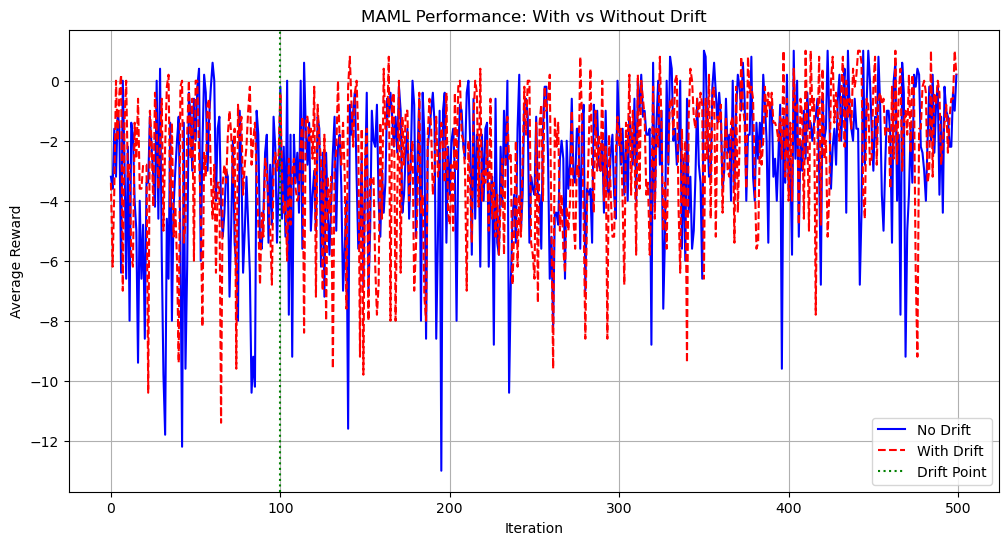

In [50]:
def plot_compare_rewards(avg_rewards_no_drift, avg_rewards_with_drift, drift_episode=None):
    """
    对比两次实验的 reward 曲线
    :param drift_episode: 标记 drift 发生的位置
    """
    plt.figure(figsize=(12, 6))
    
    # 绘制两条曲线
    plt.plot(avg_rewards_no_drift, label="No Drift", color="blue", linestyle="-")
    plt.plot(avg_rewards_with_drift, label="With Drift", color="red", linestyle="--")
    
    # 标记 drift 位置（如果有）
    if drift_episode is not None:
        plt.axvline(x=drift_episode, color="green", linestyle=":", label="Drift Point")
    
    plt.xlabel("Iteration")
    plt.ylabel("Average Reward")
    plt.title("MAML Performance: With vs Without Drift")
    plt.legend()
    plt.grid(True)
    plt.show()

# 调用绘图
plot_compare_rewards(avg_rewards_no_drift, avg_rewards_with_drift, drift_episode=100)

In [5]:
test_task = TaskEnv_drift()
test_task.set_flag()
test_task.drift(add_actions=0, add_states=0)
fast_weights = maml.adapt(test_task)
states, actions, rewards = maml.sample_trajectory(test_task, fast_weights)
test_loss = maml.compute_loss(states, actions, rewards, fast_weights)
print(f"Test Loss: {test_loss.item()}")

drift happen
Test Loss: -6.5370025634765625


/Users/veetin/Desktop/drifttest_pa/main/dynamic_env.py:47: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  frequencies[label][action] = ast.literal_eval(frequencies[label][action]) #判断需要计算的内容是不是合法的Python类型，如果是则执行，否则就报错
